<a href="https://colab.research.google.com/github/guarnieri0/GAIN/blob/master/univariate_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy

import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.metrics import mean_squared_error

In [ ]:
df = pd.read_excel(r'/content/WTG_#11_30%_miss.xlsx')
df['Time']=pd.to_datetime(df['Time'])
#df.drop(['No.','Avg Wind Speed(m/s)','Avg  Reactive Power (kVar)','Energy Yield(kWh)','Avg Yaw Position(deg)','Unnamed: 0'], inplace=True, axis=1)
#df.drop(['No.','Avg Wind Speed(m/s)','Avg  Reactive Power (kVar)','Energy Yield(kWh)','Avg Yaw Position(deg)'], inplace=True, axis=1)
df.drop(['Avg Wind Speed(m/s)','Avg  Reactive Power (kVar)','Energy Yield(kWh)','Avg Yaw Position(deg)'], inplace=True, axis=1)
df = df.set_index('Time')
print(df.info())
print(df.head())
long_dat=len(df)
df1=df.iloc[:long_dat,:]
print(df1.head())
df1[df1 < 0] = 0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52028 entries, 2018-01-01 00:00:00 to 2018-12-31 23:50:00
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Avg Active Power (kW)  36034 non-null  float64
dtypes: float64(1)
memory usage: 812.9 KB
None
                     Avg Active Power (kW)
Time                                      
2018-01-01 00:00:00                  62.12
2018-01-01 00:10:00                    NaN
2018-01-01 00:20:00                  24.94
2018-01-01 00:30:00                  25.79
2018-01-01 00:40:00                  42.33
                     Avg Active Power (kW)
Time                                      
2018-01-01 00:00:00                  62.12
2018-01-01 00:10:00                    NaN
2018-01-01 00:20:00                  24.94
2018-01-01 00:30:00                  25.79
2018-01-01 00:40:00                  42.33


In [ ]:
#IMPUTATION
#from missingpy import MissForest


df1.fillna(df1.mean(),inplace=True)

#df1.interpolate(method ='linear', limit_direction ='forward',inplace = True)

#df1.dropna(inplace=True)

#df1.isna().sum()




In [ ]:
print(df1.loc['2018-12-01 00:00:00':'2018-12-01 12:50:00'])
print(df1.isna().sum())
#df1['Avg Active Power (kW)'] = X_imput[:,3]
#df1.drop(['No.','Avg Wind Speed(m/s)','Avg  Reactive Power (kVar)','Energy Yield(kWh)','Avg Yaw Position(deg)','Unnamed: 0'], inplace=True, axis=1)
#print(df1)

                     Avg Active Power (kW)
Time                                      
2018-12-01 00:00:00                  66.32
2018-12-01 00:10:00                 101.33
2018-12-01 00:20:00                 119.65
2018-12-01 00:30:00                 101.57
2018-12-01 00:40:00                  41.80
...                                    ...
2018-12-01 12:10:00                 236.61
2018-12-01 12:20:00                 267.31
2018-12-01 12:30:00                 329.02
2018-12-01 12:40:00                 276.00
2018-12-01 12:50:00                 367.94

[78 rows x 1 columns]
Avg Active Power (kW)    0
dtype: int64


In [ ]:
#Questa funzione, ipotizzando len(dataset) = 5000, parte da 4996 e va a ricopiare il timestep 4996-4997-4998 (perchè lookback = 3) mentre il 4999 viene ricopiato in y 
# ottengo una cosa del tipo (x(4996) , x(4997) , x(4998)) -> y(4999)


def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
dataset = df1.values
print(len(dataset))
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

52028


In [ ]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train))
print(len(test))

34858
17170


In [ ]:
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape), print(trainY.shape)

(34854, 3)
(34854,)


(None, None)

In [ ]:
print(trainX)
print(trainY)

[[0.04016241 0.40060832 0.01612444]
 [0.40060832 0.01612444 0.01667399]
 [0.01612444 0.01667399 0.02736759]
 ...
 [0.40060832 0.40060832 0.40060832]
 [0.40060832 0.40060832 0.51421072]
 [0.40060832 0.51421072 0.40060832]]
[0.01667399 0.02736759 0.40060832 ... 0.51421072 0.40060832 0.71555938]


In [ ]:
trainXrs = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1],1 ))
testXrs = numpy.reshape(testX, (testX.shape[0], trainX.shape[1], 1 ))


#trainXrs = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testXrs = numpy.reshape(testX, (testX.shape[0], 1, trainX.shape[1]))

print(trainXrs.shape)
print(testXrs.shape)

(34854, 3, 1)
(17166, 3, 1)


In [ ]:
model = Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
#model.add(Dense(4, input_shape=(1, look_back), activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainXrs, trainY, epochs=30, batch_size=50, verbose=1,validation_split=0.4)

Epoch 1/30
419/419 [==============================] - 4s 6ms/step - loss: 0.0394 - val_loss: 0.0588
Epoch 2/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0282 - val_loss: 0.0552
Epoch 3/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0281 - val_loss: 0.0544
Epoch 4/30
419/419 [==============================] - 2s 4ms/step - loss: 0.0280 - val_loss: 0.0555
Epoch 5/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0279 - val_loss: 0.0563
Epoch 6/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0279 - val_loss: 0.0565
Epoch 7/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0278 - val_loss: 0.0548
Epoch 8/30
419/419 [==============================] - 2s 4ms/step - loss: 0.0278 - val_loss: 0.0558
Epoch 9/30
419/419 [==============================] - 2s 5ms/step - loss: 0.0277 - val_loss: 0.0559
Epoch 10/30
419/419 [==============================] - 2s 4ms/step - loss: 0.0277 - val_loss: 0.0548

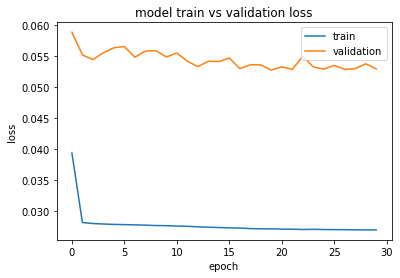

In [ ]:

from matplotlib import pyplot


pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [ ]:
trainPredict = model.predict(trainXrs)
testPredict = model.predict(testXrs)
len(trainPredict)
trainPredict.shape
testPredict.shape

(17166, 1)

In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
#trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
#stY = scaler.inverse_transform([testY])


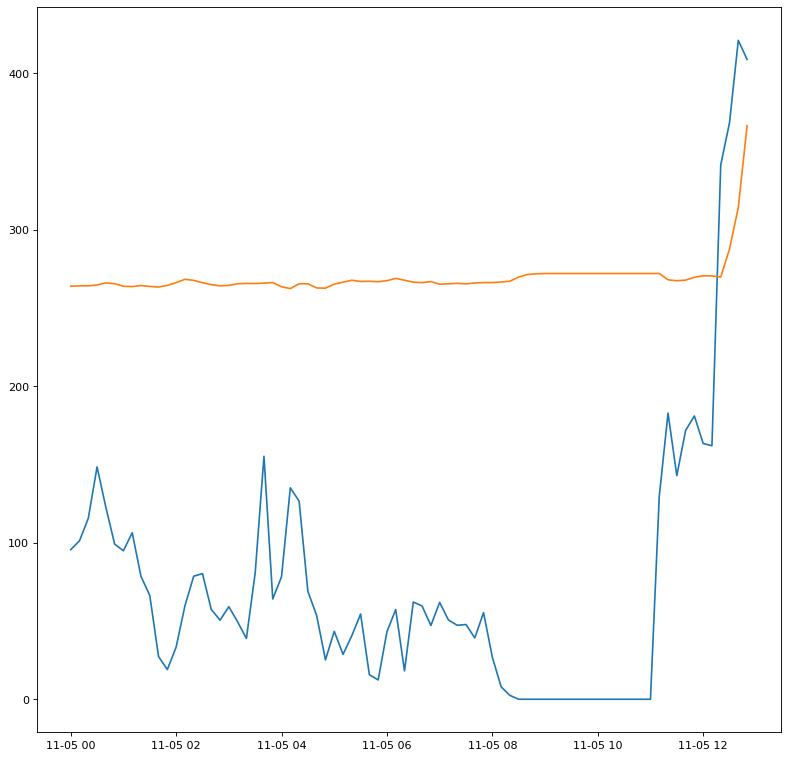

In [ ]:
# shift train predictions for plotting

from matplotlib.pyplot import figure
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting


#testPredictPlot = numpy.empty_like(dataset)
testPredictPlot = numpy.empty_like(dataset)



testPredictPlot[:, :] = numpy.nan
#testPredictPlot[:] = numpy.nan



testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
figure(figsize=(12, 12), dpi=80)


#adding dates to the prevision

dates = df1.index.to_list()
frcst = testPredictPlot.reshape(len(df1))
True_Power = df1["Avg Active Power (kW)"].to_list()


Machine_Df = pd.DataFrame(data={
    "Date":dates,
   "Avg Active Power": True_Power,
   "Predicted Active Power": frcst
    })
Machine_Df.set_index('Date', inplace=True)


# plot baseline and predictions

#plt.plot(Machine_Df.[8000:8060,0])
plt.plot(Machine_Df.loc['2018-11-05 00:00:00':'2018-11-05 12:50:00'])
# Machine_Df.loc['2018-04-30 23:50:00' : '2018-05-01 13:50:00'] 

#testPredictPlot.
#plt.plot(scaler.inverse_transform(dataset[180:200]))
#plt.plot(trainPredictPlot)
#plt.plot(testPredictPlot[180:200])
plt.show()


In [ ]:
print(Machine_Df.loc['2018-11-01 00:00:00':'2018-11-01 12:50:00'])

                     Avg Active Power  Predicted Active Power
Date                                                         
2018-11-01 00:00:00           1509.41             1090.592529
2018-11-01 00:10:00           1332.65             1092.203857
2018-11-01 00:20:00           1247.65             1079.056641
2018-11-01 00:30:00           1408.13             1074.868774
2018-11-01 00:40:00           1461.78             1087.820801
...                               ...                     ...
2018-11-01 12:10:00            734.70              874.416199
2018-11-01 12:20:00            580.57              800.429688
2018-11-01 12:30:00            635.74              711.049194
2018-11-01 12:40:00            594.59              655.301025
2018-11-01 12:50:00            398.38              595.877502

[78 rows x 2 columns]


In [ ]:
Machine_Df.reset_index(inplace= True)
print(Machine_Df.tail)

<bound method NDFrame.tail of                      Date  Avg Active Power  Predicted Active Power
0     2018-01-01 00:00:00         62.120000                     NaN
1     2018-01-01 00:10:00        619.628896                     NaN
2     2018-01-01 00:20:00         24.940000                     NaN
3     2018-01-01 00:30:00         25.790000                     NaN
4     2018-01-01 00:40:00         42.330000                     NaN
...                   ...               ...                     ...
52023 2018-12-31 23:10:00       1542.140000             1084.056519
52024 2018-12-31 23:20:00       1533.840000             1084.303101
52025 2018-12-31 23:30:00       1537.780000             1084.005737
52026 2018-12-31 23:40:00       1531.780000             1084.221680
52027 2018-12-31 23:50:00       1543.430000                     NaN

[52028 rows x 3 columns]>


In [ ]:

Machine_Df.to_excel('WTG #11 forecast_mean_30%.xlsx', index = False)